In [1]:
import notebook_import_hook
notebook_import_hook.attach()
from globals import *

In [ ]:
class staticclass(type):
    class InstantiationError(Exception):
        pass
    def __new__(cls, name, parents, attrs):
        for k, v in list(dict.items(attrs)):
            if not isinstance(v, staticmethod) and callable(v):
                attrs[k] = staticmethod(v)
        return super(__class__, __class__).__new__(cls, name, parents, attrs)
    def __call__(cls, *a, **k):
        raise __class__.InstantiationError('cannot instantiate a staticclass')

In [ ]:
def flatten(*it):
    for x in it:
        try:
            assert not isinstance(x, str)
            yield from flatten(*x)
        except (TypeError, AssertionError):
            yield x

** need to add to Kaggle ^**

In [71]:
def rolling_windows_axis0(a, size, step=1):
    '''backward rolling window only
    windows dimension will be appended to a.shape (available at index -1)'''
    a_ext = np.concatenate(( np.full((step*(L-1),)+a.shape[1:],np.nan) ,a))
    n = a_ext.strides[0]
    strided = np.lib.stride_tricks.as_strided     
    return strided(a_ext, shape=a.shape+(L,), strides=a_ext.strides+(step*n,))

In [72]:
#a = (np.random.rand(8, 5)*1000).astype(int)
#a

array([[701, 349, 851, 487, 957],
       [687,  53, 938, 757, 976],
       [846, 573, 337, 116, 306],
       [754, 541, 985, 415, 432],
       [414,  53, 596,  22, 906],
       [670, 741, 274, 473, 361],
       [351, 522, 266, 662, 467],
       [199, 179, 479, 398, 275]])

In [77]:
#rolling_windows_1d(a, 3, step=2)[:, -1]

array([[  nan,   nan,  957.],
       [  nan,   nan,  976.],
       [  nan,  957.,  306.],
       [  nan,  976.,  432.],
       [ 957.,  306.,  906.],
       [ 976.,  432.,  361.],
       [ 306.,  906.,  467.],
       [ 432.,  361.,  275.]])

In [1]:
from collections import namedtuple

NamedTuple = lambda typename, fields, values: namedtuple(typename, fields)(*values)

In [ ]:
def lens(*it):
    return tuple(len(x) for x in it)
def shapes(*arrs):
    return tuple(x.shape for x in arrs)
def sums(*it):
    return tuple(sum(x) for x in it)

In [ ]:
offdiag = lambda a: a[np.where(~np.eye(a.shape[0],dtype=bool))]
nonnans = lambda a: a[np.isfinite(a)]

In [ ]:
def shift(a, shift, axis=None):
    '''Params - a: np.ndarray
                shift: integer, + means entries moved to greater indices, - means entries moved to smaller indices
                axis: one integer
    Equivalent to pd.DataFrame.shift
    '''
    if axis is None:
        assert len(a.shape)==1, "Only an array of single dimension can be shifted without specifying axis"
        axis = 0
    assert isinstance(axis, int)
    if not shift:
        return a
    padding = (shift,0) if shift>0 else (0,-shift)
    slicing = slice(None,-shift) if shift>0 else slice(-shift,None)
    n = len(a.shape)
    axis = n+axis if axis<0 else axis
    ret = np.pad(a, ((0,0),)*axis+(padding,)+((0,0),)*(n-axis-1), mode='constant', constant_values=(np.nan,)*n)
    ret = ret[(slice(None),)*axis + (slicing,) + (slice(None),)*(n-axis-1)]
    return ret
np.shift = shift

In [ ]:
def print_progress(i, dot=1, numdot=10):
    print('.' if i // dot % numdot else i, end='', flush=True) if i % dot == 0 else None

In [26]:
from contextlib import contextmanager

@contextmanager
def let(**var):
    '''Example usage:
    >>> var1 = 50
    >>> with let(var1=200, var2=33):
    >>>   result = var1 + var2
    >>> var1
    50
    >>> result
    233
    '''
    class NotDefined():
        pass
    NDEF = NotDefined()
    orig = {k: (globals()[k] if k in globals() else NDEF) for k in var}
    globals().update(**var)
    yield orig
    globals().update(**orig)
    
@contextmanager
def put(**var):
    '''Example usage:
    >>> var1 = 50
    >>> with put(var1=200, var2=33):
    >>>   result = var1 + var2
    >>> var1
    200
    >>> var2
    33
    >>> result
    233
    '''
    class NotDefined():
        pass
    NDEF = NotDefined()
    orig = {k: (globals()[k] if k in globals() else NDEF) for k in var}
    globals().update(**var)
    yield orig

In [21]:
@property
def _chain(self):
    '''ready `self` for chaining a method that does a side effect but returns nothing. Example:
    >>> df = pd.DataFrame({'hi': [1,2,3,4]}, index=[5,6,9,2])
    >>> result = df.chain.sort_index(inplace=True)
    # `result` is equivalent to `df.sort_index()`
    '''
    class Chain():
        def __getattribute__(this, *args, **kw):
            method = self.__getattribute__(*args, **kw)
            @wraps(method)
            def chained(*args, **kw):
                method(*args, **kw)
                return self
            return chained
    return Chain()
pd.DataFrame.chain = _chain
pd.Series.chain = _chain

if __name__ == '__main__':
    df = pd.DataFrame({'a':[9,np.nan,0],'b':[5,5,np.nan]})
    test = df.chain.fillna(0, inplace=True)
    assert test is df

In [ ]:
def rename(series, name):
    '''rename `series` name to `name` and return `series`'''
    series.name = name
    return series
pd.Series.rename = rename

def colname_append(df, suffix, level=None):
    '''Params - df: `DataFrame`
                suffix: `str`
                level: `int` of the column level at which to append label suffix. use only if `df` has multiindex column
    Append `suffix` to the label names of `df` columns, at level `level` of multiindex if applicable'''
    if level is None:
        df.columns = df.columns + suffix
    else:
        df.columns = df.columns.set_levels(df.columns.levels[level] + suffix, level=level)
    return df
pd.DataFrame.colname_append = colname_append

In [ ]:
def repeat_like(small, df):
    '''Params - small: `DataFrame`
                df: `DataFrame`
    Assume `small` has same shape as `df` with only the last dimension of column multiindex.
    Repeats `small` columnwise until has shape as `df`.'''
    ret = pd.concat([small] * prod(lvl.shape[0] for lvl in list(df.columns.levels)[:-1]), axis=1)
    ret.columns = df.columns
    return ret
pd.DataFrame.repeat_like = repeat_like

def wide_filter(df, filter):
    '''Params - df: `DataFrame`
                filter: boolean array
    only handles `filter` being the -1 level of columns (TODO: handle all levels) and no labels being missing
    from the `df.columns.levels` in the actual column labels.'''
    if isinstance(df.columns, pd.MultiIndex):
        return df.iloc[:, np.concatenate([filter] * prod(lvl.shape[0] for lvl in list(df.columns.levels)[:-1]))]
    else:
        return df.T[filter].T
pd.DataFrame.wide_filter = wide_filter

In [ ]:
def only_nans(a):
    '''`a` but with all non-NaN values replaced with 0'''
    if isinstance(a, pd.DataFrame) or isinstance(a, pd.Series):
        return a.isna().replace(True, np.nan)
    else:
        a = a.copy()
        a[~np.isnan(a)] = 0
        return a

In [ ]:
def broadcast(a, b, op):
    ''' return `eval('a{}b'.format(op))`, with `a` and `b` transposed as necessary to carry out the op'''
    magic = {'+': '__add__', '*': '__mul__'}
    if not isinstance(a, pd.DataFrame):
        assert isinstance(b, pd.DataFrame), 'one of `a` or `b` must be a `DataFrame`!'
        a, b = b, a
    try:
        try:
            return a.__getattribute__(magic[op])(b)
        except ValueError:
            return a.T.__getattribute__(magic[op])(b).T
    except:
        raise

In [2]:
def quantile_normal(a):
    from scipy.stats import norm
    return norm.ppf(a) + a * 0

In [2]:
def center(matrix):
    '''Params - matrix: pandas.DataFrame without NaNs
    Effectively returns C @ matrix @ C, where C is the centering matrix of appropriate dimensions.'''
    assert not np.isnan(matrix).any().any()
    demean = lambda x: x - x.mean()
    return matrix.pipe(demean).T.pipe(demean).T

In [ ]:
def quantile_transform_old(X, positive=False):
    '''Params - X: `DataFrame` of observations (has maybe NaNs), positive: (`bool`) if values are > 0 intrinsically
    Return "canonical" use quantile transformed (per column) values for X
    DEPRECIATED'''
    bot = X.min().min() - 1 if not positive else 0
    Y = X.append(pd.Series(bot, index=X.columns), ignore_index=True)
    method = 'max' if positive else 'average'
    pct = 1 - Y.rank(pct=True, ascending=False, method=method)
    pct.drop(pct.index[-1], inplace=True)
    pct.index = X.index
    return pct

def quantile_transform(X):
    '''Params - X: `DataFrame` of observations (has maybe NaNs)
    Return unbiased estimate of (cf German tank problem) quantile transformed (per column) values for X'''
    themax = X.max().max()
    themin = X.min().min()
    top = themax + (themax - themin)
    imin = X.index.min()
    imax = X.index.max()
    itop = imax + (imax - imin)
    X.loc[itop] = pd.Series(top, index=X.columns)
    try:
        pct = X.rank(pct=True)
    finally:
        X.drop(X.index[-1], inplace=True)
    pct.drop(pct.index[-1], inplace=True)
    return pct
pd.DataFrame.qtl = quantile_transform

def quantile_transform_series(X):
    '''Params - X: `Series` of observations (has maybe NaNs)
    Return unbiased estimate of (cf German tank problem) quantile transformed values for X'''
    themax = X.max().max()
    themin = X.min().min()
    top = themax + (themax - themin)
    imin = X.index.min()
    imax = X.index.max()
    itop = imax + (imax - imin)
    X.loc[itop] = top
    try:
        pct = X.rank(pct=True)
    finally:
        X.drop(X.index[-1], inplace=True)
    pct.drop(pct.index[-1], inplace=True)
    return pct
pd.Series.qtl = quantile_transform_series

#def weighted_percentile_transform(X, weights):
#    W = weights[~X.isna()]
#    Wsort = W.values_sort(X)
#    rev = X.values.argsort(axis=0).argsort(axis=0)
#    wavg, wsum = W.mean(), W.count()
#    Wavg, Wsum = wavg.values[np.newaxis, :], wsum.values[np.newaxis, :]
#    pct = (Wavg + Wsort.cumsum() - Wsort / 2) / (Wsum + Wavg * 2)
#    pct = pct[rev, np.arange(pct.shape[1])]
#    return pd.DataFrame(pct, index=X.index, columns=X.columns)

#pd.DataFrame.pct = percentile_transform

In [ ]:
def values_sort(X, key=None, order=None):
    '''Params - X: 2D array-like
                key: 2D array-like same shape as `X`
                order: 2D array-like of index ints (same shape)
    Return values of `X` (as `ndarray`) sorted columnwise by the values of `key` or
    according to `order` row indices (per each column). `key` is `X` by default unless `order` is specified.'''
    assert key is None or order is None, '`key` and `order` cannot both be given'
    assert not key.isna().any().any(), '`key` must not contain NaNs!'
    if order is None and key is None:
        key = X
    if order is None:
        if not isinstance(key, np.ndarray):
            key = key.values
        order = key.argsort(axis=0)
    values = X
    if not isinstance(X, np.ndarray):
        values = values.values
    return values[(order,) + ((np.arange(X.shape[1]),) if len(X.shape) > 1 else ())]

pd.DataFrame.values_sort = values_sort
pd.Series.values_sort = values_sort

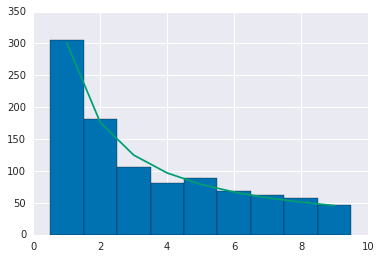

In [160]:
def lead_digit(x):
    '''the leading decimal digit of `x`'''
    return np.abs(x) // 10 ** (np.floor(np.log10(np.abs(x))))

#lead_digit = np.vectorize(lead_digit)

def plot_benford(a, *args, **kwargs):
    benford = np.log10(1 + 1 / np.arange(1, 10))
    ld = lead_digit(a)
    plt.hist(ld[~np.isnan(ld)], bins=np.arange(0.5, 10))
    plt.plot(np.arange(1, 10), benford * (~np.isnan(a)).sum())
    
if __name__ == '__main__':
    %matplotlib inline
    #plot_benford(np.random.exponential(size=1000))

In [ ]:
def feature_filter(x, feats):
    import re
    return x[[c for c in x.columns if any(re.match('{0}\W|{0}$'.format(f), c) for f in feats)]]